## Integrantes:

1.- Darwin Varas.

2.- Manuel Berrospi.

3.- Carlos Mercedes.


# **Ejercicio 1: Detección de mascarillas faciales en espacios públicos con AlexNet**

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import numpy as np

In [ ]:
# =============================
# 0. Descomprimir el archivo ZIP
# =============================
import zipfile

zip_path = "/content/mask_dataset_classification.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# =============================
# 1. Cargar dataset desde carpeta clasificada
# =============================
data_dir = "/content/mask_dataset_classification"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# División 80/20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
# =============================
# 2. Cargar modelo AlexNet y ajustar
# =============================
model = models.alexnet(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 55.8MB/s]


In [ ]:
# =============================
# 3. Entrenamiento
# =============================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=5):
    history = {'loss': [], 'acc': []}
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = running_loss / len(train_loader)
        acc = correct / total
        history['loss'].append(avg_loss)
        history['acc'].append(acc)
        print(f"Época {epoch+1}: Pérdida = {avg_loss:.4f}, Accuracy = {acc:.2%}")
    return history

history = train_model(model, train_loader, criterion, optimizer, epochs=5)

Época 1: Pérdida = 0.5758, Accuracy = 98.48%
Época 2: Pérdida = 0.4185, Accuracy = 96.96%
Época 3: Pérdida = 0.0378, Accuracy = 99.24%
Época 4: Pérdida = 0.0126, Accuracy = 99.62%
Época 5: Pérdida = 0.1588, Accuracy = 99.24%


Accuracy en test set: 90.91%
F1 Score (ponderado): 91.20%


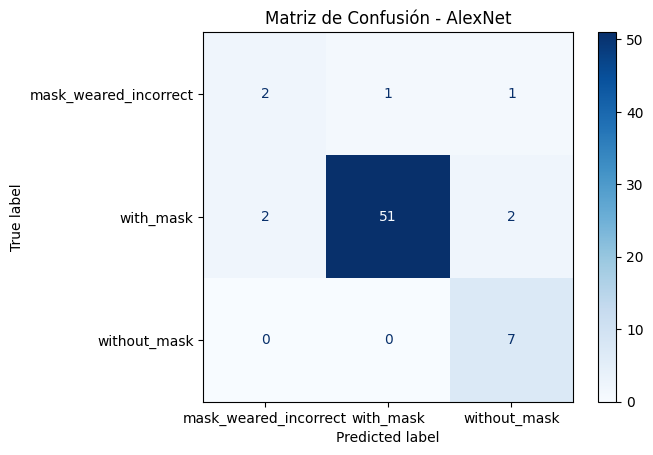

In [ ]:
# =============================
# 4. Evaluación
# =============================
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy en test set: {acc:.2%}")
print(f"F1 Score (ponderado): {f1:.2%}")

cm = confusion_matrix(y_true, y_pred)
class_names = dataset.classes
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap="Blues")
plt.title("Matriz de Confusión - AlexNet")
plt.show()

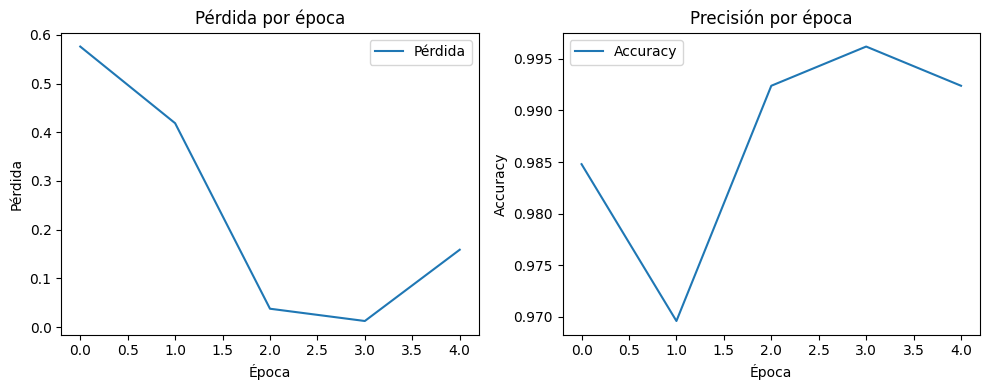

In [ ]:
# =============================
# 5. Gráfico de entrenamiento
# =============================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='Pérdida')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['acc'], label='Accuracy')
plt.title("Precisión por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# **Pregunta de reflexión**

**¿Por qué podría ser riesgoso que un modelo de clasificación facial se entrene con pocas imágenes de una de las clases (por ejemplo, “mascarilla mal puesta”)?**

Entrenar un modelo de visión computacional con un conjunto limitado de clases o con una distribución muy desbalanceada de datos puede traer riesgos importantes, especialmente en contextos sensibles como la salud pública. A continuación, se detallan los principales motivos:

 a) Generalización limitada

Si el modelo ha sido entrenado con pocos ejemplos por clase, no aprende correctamente la variabilidad intra-clase (diferencias entre imágenes que pertenecen a la misma categoría).

Por ejemplo, si sólo ha visto personas con “mascarilla mal puesta” desde un ángulo o tipo de rostro específico, puede fallar al clasificar otros casos reales que difieren en edad, género, iluminación, fondo, o tipo de mascarilla.

 b) Riesgo de sobreajuste (overfitting)

Con pocos datos o pocas clases, el modelo tiende a memorizar las imágenes de entrenamiento.

Esto lleva a un alto rendimiento en el set de entrenamiento pero un rendimiento pobre en imágenes nuevas (mal rendimiento generalizado).

 c) Problemas en clases críticas o sensibles

En este caso, la clase “mascarilla mal puesta” es particularmente importante desde una perspectiva sanitaria, porque representa un incumplimiento en el uso adecuado de la mascarilla.

Si el modelo no puede identificar correctamente este caso, se incurre en falsos negativos peligrosos, donde una persona potencialmente riesgosa es clasificada erróneamente como “con mascarilla”.

 d) Desbalance de clases

Es frecuente que los datasets públicos no estén equilibrados (por ejemplo, más imágenes con mascarilla que sin ella), lo que sesga el modelo hacia las clases mayoritarias.

Esto lleva a predicciones desequilibradas y métricas engañosas como una alta accuracy pero bajo F1-score en las clases minoritarias.

**¿Cómo podría mejorarse el rendimiento del modelo?**

Para mejorar el rendimiento de un modelo de clasificación como el que están trabajando, se pueden aplicar diversas estrategias tanto desde el lado del preprocesamiento de datos, como en el ajuste del modelo. A continuación, se mencionan:

a) Aplicar data augmentation (rotaciones, recortes, brillo) para más variedad.

b) Descongelar algunas capas de AlexNet (fine-tuning).

c) Ajustar hiperparámetros como learning rate y número de épocas.

d) Usar modelos más modernos como ResNet o MobileNet.

e) Rebalancear las clases o ajustar la función de pérdida con pesos.

f) Usar validación cruzada para medir mejor el rendimiento.

# **Ejercicio 2: Clasificación de expresiones faciales con VGG16**

In [ ]:
import os
import zipfile
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import numpy as np

In [ ]:
# =============================
# 0. Descargar FER-2013 desde Kaggle
# =============================
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d msambare/fer2013 -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.33GB/s]


In [ ]:
# =============================
# 1. Cargar dataset FER-2013
# =============================
data_dir = "/content"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
test_set = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
# =============================
# 2. Cargar modelo VGG16 y adaptar
# =============================
model = models.vgg16(pretrained=True)
for param in model.features[:24].parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 7)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 192MB/s]


In [ ]:
# =============================
# 3. Entrenamiento
# =============================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, train_loader, criterion, optimizer, epochs=5):
    history = {'loss': [], 'acc': []}
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = running_loss / len(train_loader)
        acc = correct / total
        history['loss'].append(avg_loss)
        history['acc'].append(acc)
        print(f"Época {epoch+1}: Pérdida = {avg_loss:.4f}, Accuracy = {acc:.2%}")
    return history

history = train_model(model, train_loader, criterion, optimizer, epochs=5)

Época 1: Pérdida = 1.3374, Accuracy = 48.93%
Época 2: Pérdida = 1.0702, Accuracy = 59.95%
Época 3: Pérdida = 0.9285, Accuracy = 65.52%
Época 4: Pérdida = 0.8008, Accuracy = 70.17%
Época 5: Pérdida = 0.6566, Accuracy = 76.10%



Accuracy en test set: 66.12%
F1 Score (ponderado): 65.90%


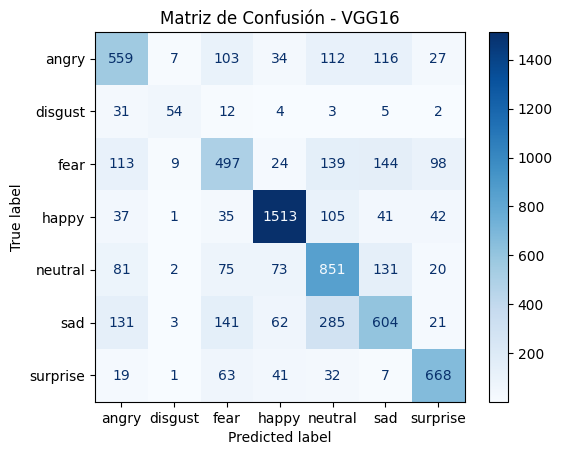

In [ ]:
# =============================
# 4. Evaluación
# =============================
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nAccuracy en test set: {acc:.2%}")
print(f"F1 Score (ponderado): {f1:.2%}")

cm = confusion_matrix(y_true, y_pred)
class_names = train_set.classes
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap="Blues")
plt.title("Matriz de Confusión - VGG16")
plt.show()

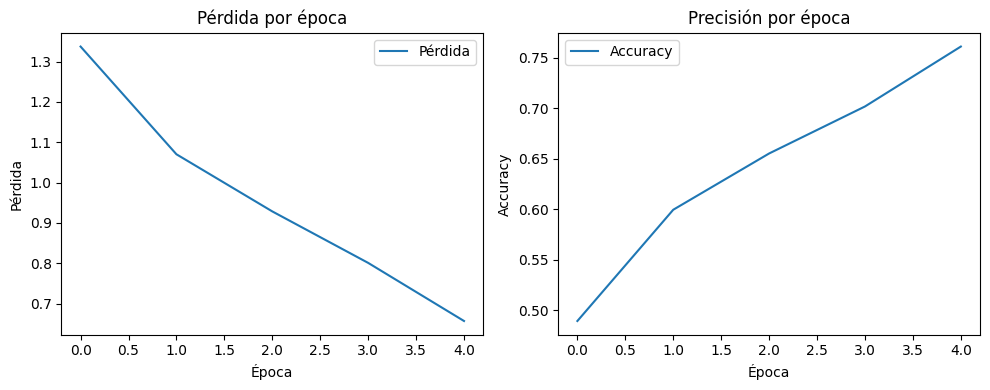

In [ ]:
# =============================
# 5. Gráfico de entrenamiento
# =============================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='Pérdida')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['acc'], label='Accuracy')
plt.title("Precisión por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# **Pregunta de reflexión**

**¿Cuál es la principal ventaja de utilizar el modelo VGG16 pre-entrenado en esta tarea?**

La principal ventaja es que VGG16 ya ha sido entrenado con millones de imágenes (ImageNet), por lo que ya ha aprendido a detectar características visuales generales (bordes, texturas, formas). Esto permite que el modelo reconozca patrones útiles sin necesidad de entrenar desde cero, ahorrando tiempo, datos y recursos computacionales.
Además, mejora la precisión y acelera la convergencia del modelo.

**¿Cómo elige el número de neuronas en la capa de salida?**

El número de neuronas debe coincidir con la cantidad de clases del problema.
En este caso, el dataset FER-2013 tiene 7 emociones (angry, disgust, fear, happy, sad, surprise, neutral), por lo tanto la capa de salida debe tener 7 neuronas, una por cada clase, con activación softmax implícita a través de CrossEntropyLoss.